In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
file_path = "results/All_Results_to_annotate_ToShare.xlsx"
data = pd.read_excel(file_path)

<Axes: xlabel='Final Rating'>

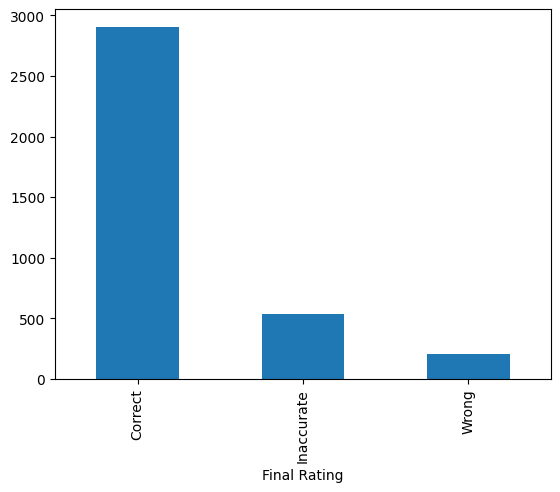

In [3]:
data["Final Rating"] = data["Final Rating"].str.capitalize()
data["Final Rating"].value_counts().plot(kind='bar')

In [4]:
data["Final Rating"].value_counts().sum()


np.int64(3640)

In [5]:
data["model"].unique()

array(['OpenEvidence', 'sonar', 'sonar-pro', 'sonar-reasoning-pro'],
      dtype=object)

<Axes: xlabel='whitelisted_bool'>

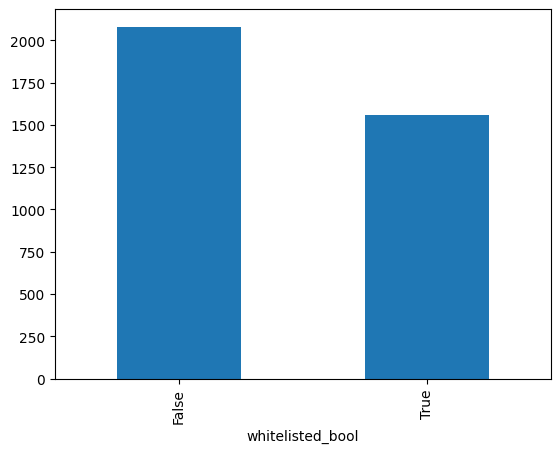

In [6]:
data["whitelisted_bool"] = data["whitelist"].notna()
data["whitelisted_bool"].value_counts().plot(kind='bar')

In [7]:
# Combine model and whitelist status into a category
data["model_category"] = data["model"] + "_" + data["whitelisted_bool"].astype(str)

category_mapping = {
    "OpenEvidence_False": "OpenEvidence (Assumed WL)",
    "OpenEvidence_True": "OpenEvidence + WL",
    "sonar_False": "Sonar",
    "sonar_True": "Sonar + WL",
    "sonar-pro_False": "Sonar-Pro",
    "sonar-pro_True": "Sonar-Pro + WL",
    "sonar-reasoning-pro_False": "Sonar-Reasoning-Pro",
    "sonar-reasoning-pro_True": "Sonar-Reasoning-Pro + WL",
}

# Apply the mapping
data["model_category"] = data["model_category"].map(category_mapping)
data["model_category"].unique()


array(['OpenEvidence (Assumed WL)', 'Sonar', 'Sonar + WL', 'Sonar-Pro',
       'Sonar-Pro + WL', 'Sonar-Reasoning-Pro',
       'Sonar-Reasoning-Pro + WL'], dtype=object)

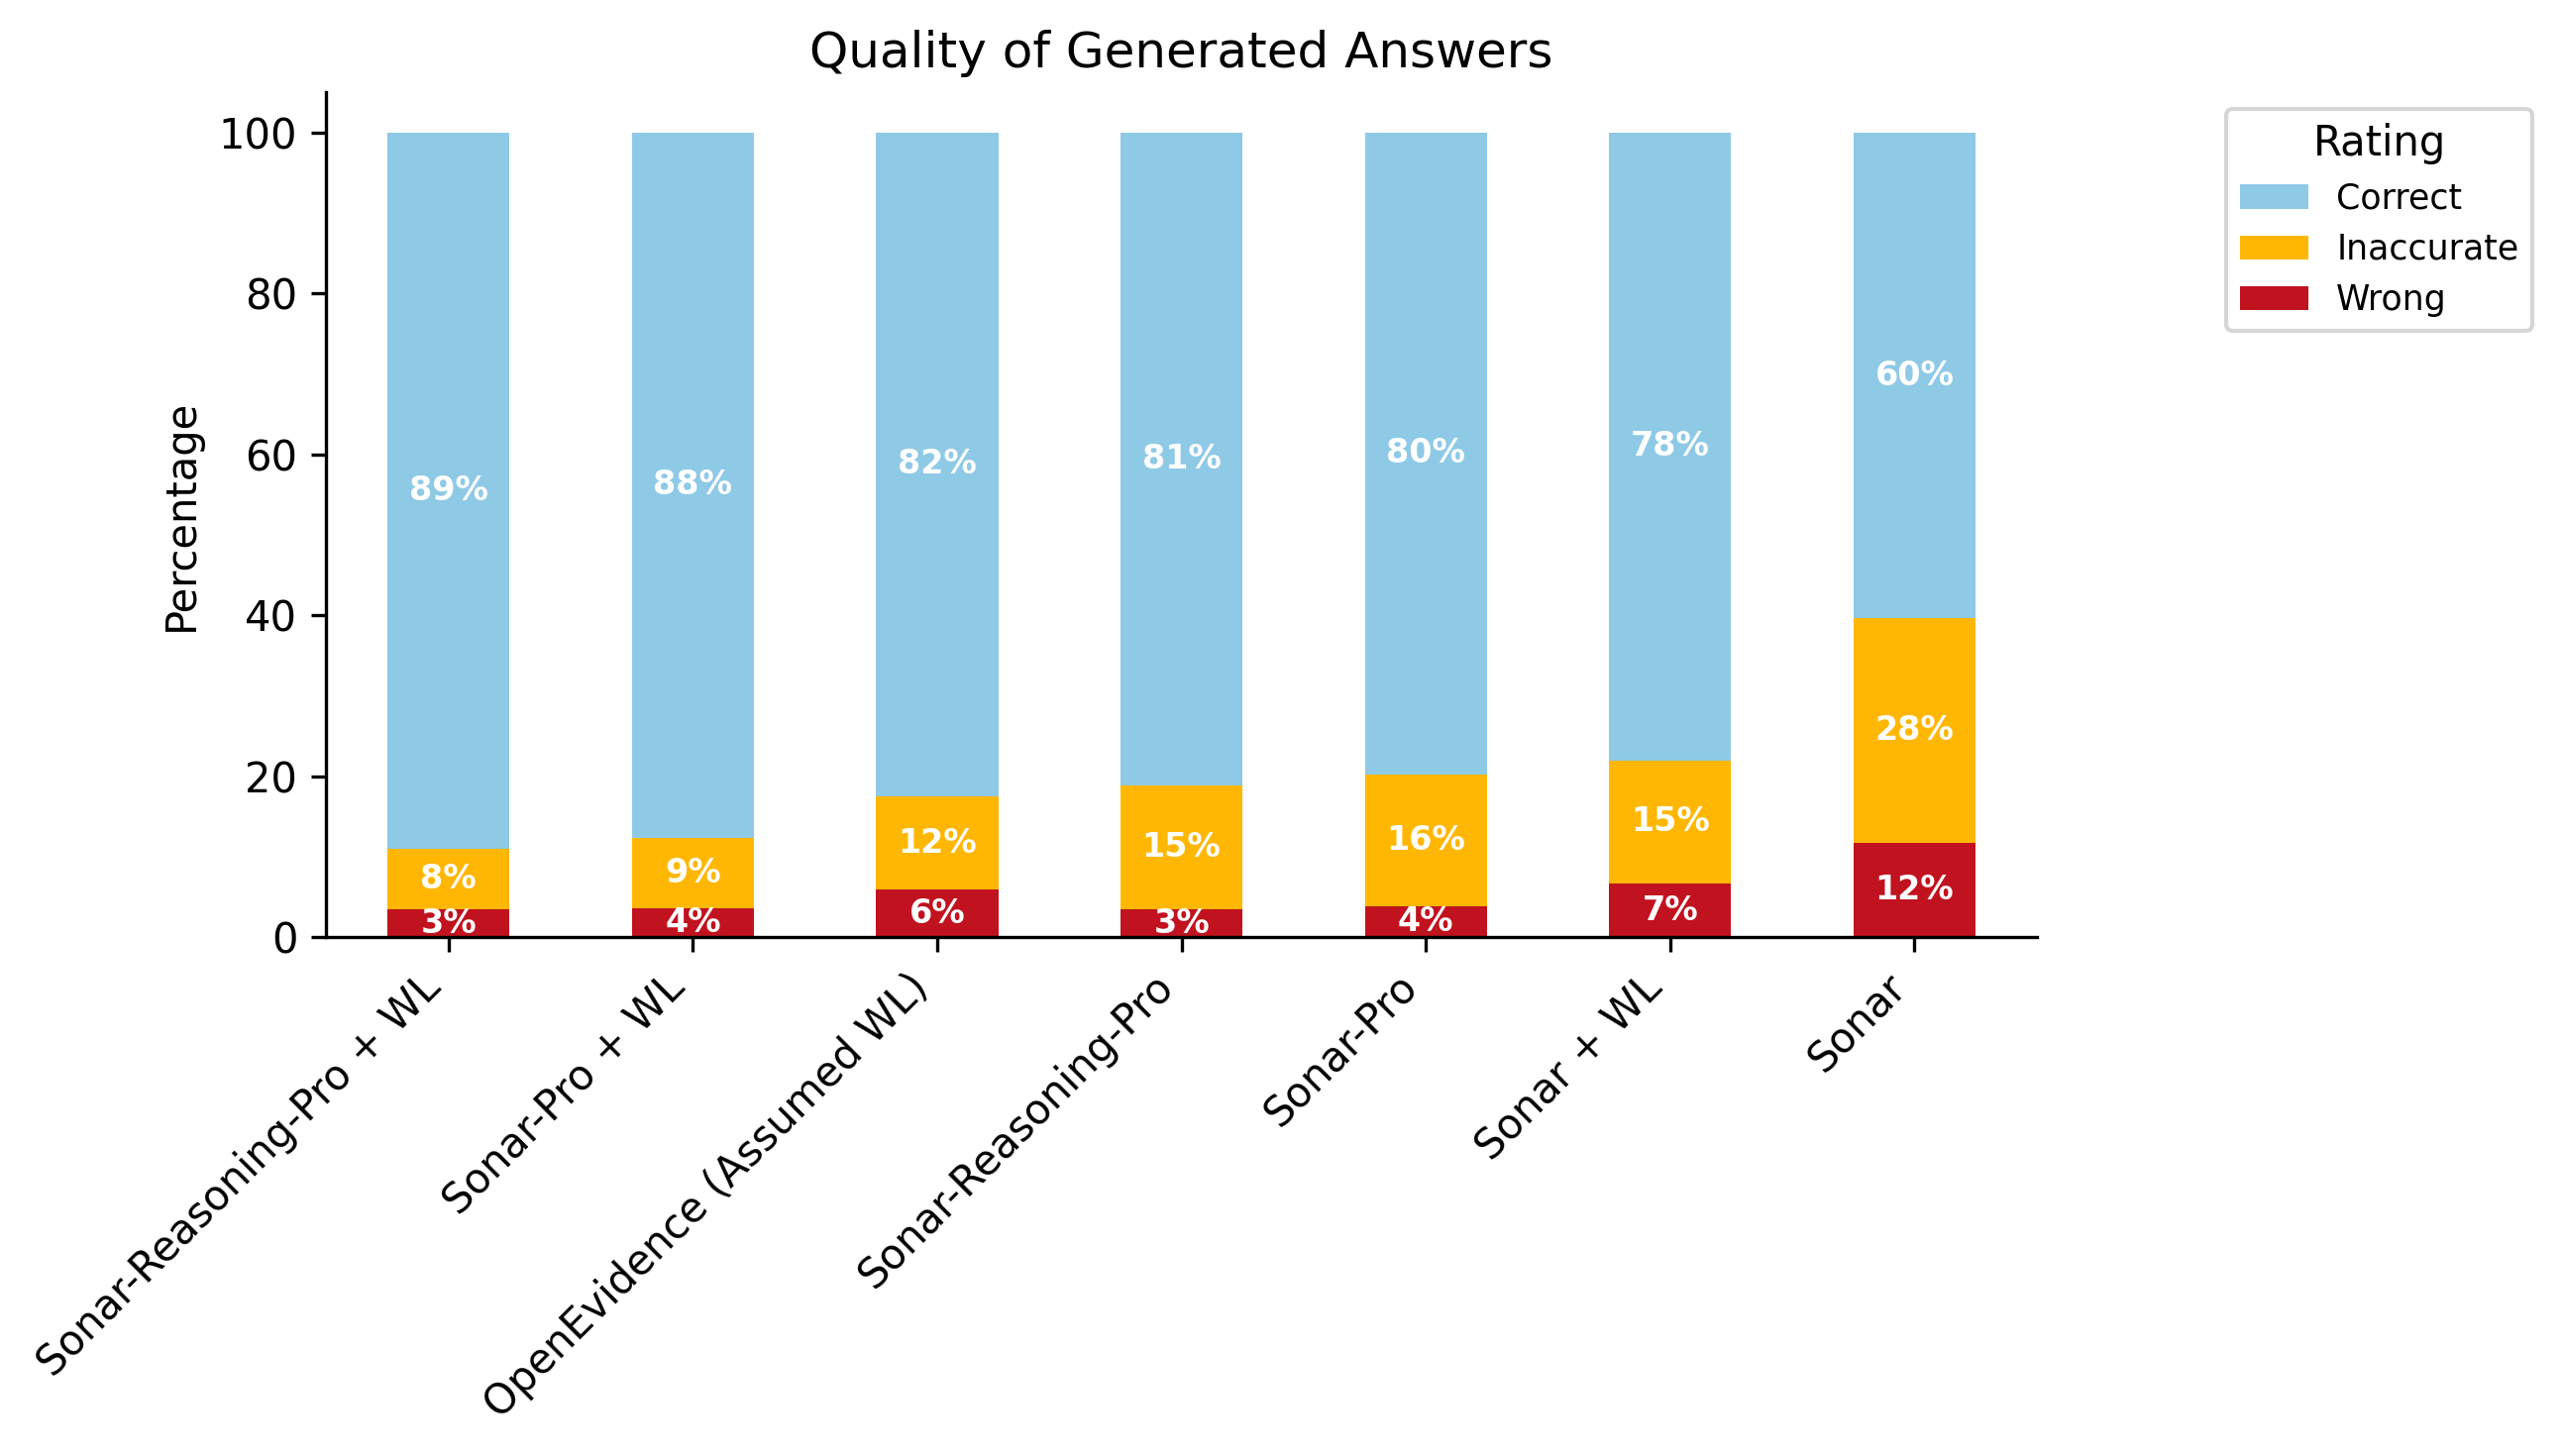

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


# 2. Helper to format percent labels
def custom_label_func(labels):
    return [f'{label:.0f}%' if float(label) > 0 else '' for label in labels]

# 3. Compute rating distributions and sort by 'Correct'
rating_counts = (
    data
    .groupby('model_category')['Final Rating']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    * 100
)
sorted_models = rating_counts.sort_values('Correct', ascending=False).index

# 4. Plot only the “Quality of Generated Answers” panel
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

bars = rating_counts.loc[sorted_models][['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar',
    stacked=True,
    color=['#c1121f', '#ffb703', '#8ecae6'],  # Wrong, Inaccurate, Correct
    ax=ax
)

# Add labels or asterisks for small slices
for container in bars.containers:
    heights = [rect.get_height() for rect in container]
    labels = custom_label_func(heights)
    for rect, label in zip(container, labels):
        h = rect.get_height()
        x = rect.get_x() + rect.get_width() / 2
        # Center the label; if very small, shift it slightly
        y = rect.get_y() + (h / 2 if h > 1 else h / 4)
        if h > 1:
            ax.text(x, y, label, ha='center', va='center', fontsize=8, weight='bold', color='white')
        elif h > 0:
            ax.text(x, y, '*', ha='center', va='center', fontsize=10, weight='bold', color='white')

# Annotate and format
#ax.text(-0.1, 1.1, 'a', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax.set_title('Quality of Generated Answers')
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_xticklabels(sorted_models, rotation=45, ha='right')

# Legend (reverse order so 'Correct' appears first)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[::-1],
    labels=['Correct', 'Inaccurate', 'Wrong'],
    title='Rating',
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    fontsize='small'
)

plt.tight_layout()
plt.savefig('Visualizations/Fig_2_rating.png', dpi=300)
plt.show()

In [9]:

# Give out a table with the absolute as well as percentage of correct, inaccurate and wrong answers for each model
rating_counts = data.groupby('model_category')['Final Rating'].value_counts().unstack().fillna(0)
rating_counts['Total'] = rating_counts.sum(axis=1)
#add percentage columns
rating_counts['Correct (%)'] = rating_counts['Correct'] / rating_counts['Total'] * 100
rating_counts['Inaccurate (%)'] = rating_counts['Inaccurate'] / rating_counts['Total'] * 100
rating_counts['Wrong (%)'] = rating_counts['Wrong'] / rating_counts['Total'] * 100
rating_counts.sort_values('Correct (%)', ascending=False, inplace=True)
#round to 1 decimal
rating_counts = rating_counts.round(1)
rating_counts

Final Rating,Correct,Inaccurate,Wrong,Total,Correct (%),Inaccurate (%),Wrong (%)
model_category,,,,,,,
Sonar-Reasoning-Pro + WL,463,39,18,520,89.0,7.5,3.5
Sonar-Pro + WL,456,45,19,520,87.7,8.7,3.7
OpenEvidence (Assumed WL),429,60,31,520,82.5,11.5,6.0
Sonar-Reasoning-Pro,422,80,18,520,81.2,15.4,3.5
Sonar-Pro,415,85,20,520,79.8,16.3,3.8
Sonar + WL,406,79,35,520,78.1,15.2,6.7
Sonar,314,145,61,520,60.4,27.9,11.7


In [10]:
from docx import Document
from docx.shared import Pt, Inches
from docx.oxml import OxmlElement
from docx.oxml.ns import qn

# Helper to write into a cell with proper font
def set_cell_text(cell, text, bold=False, font_size=12):
    para = cell.paragraphs[0]
    run = para.add_run(str(text))
    run.bold = bold
    run.font.name = 'Times New Roman'
    run._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
    run.font.size = Pt(font_size)

# — Create the document
doc = Document()
style = doc.styles['Normal']
style.font.name = 'Times New Roman'
style._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
style.font.size = Pt(12)

doc.add_heading('Distribution of Ratings by Model', level=1)
doc.add_paragraph(
    'Absolute counts and percentages of Correct, Inaccurate, and Wrong ratings for each model.', 
    style='Normal'
)

# — Prepare renamed headers
orig = rating_counts.reset_index()
headers = [
    'Model Category' if h == 'model_category' else h
    for h in orig.columns.tolist()
]

# — Build the table
table = doc.add_table(rows=1, cols=len(headers))
table.style = 'Table Grid'

# Header row
for idx, col_name in enumerate(headers):
    set_cell_text(table.rows[0].cells[idx], col_name, bold=True)

# Data rows
for _, row in orig.iterrows():
    cells = table.add_row().cells
    for idx, col_name in enumerate(orig.columns):
        set_cell_text(cells[idx], row[col_name])

# — Fix column widths via fixed layout
# Turn off autofit by setting tblLayout to fixed
tbl_pr = table._tbl.tblPr
tbl_layout = OxmlElement('w:tblLayout')
tbl_layout.set(qn('w:type'), 'fixed')
tbl_pr.append(tbl_layout)

# Set each column to 1.5"
col_width = Inches(0.9)
twips = str(int(col_width.inches * 1440))
for col in table.columns:
    for cell in col.cells:
        tcPr = cell._tc.get_or_add_tcPr()
        tcW = OxmlElement('w:tcW')
        tcW.set(qn('w:w'), twips)
        tcW.set(qn('w:type'), 'dxa')
        tcPr.append(tcW)

# — Save
output_path = 'results/Rating_Distribution_by_Model.docx'
doc.save(output_path)
print(f'📄 Word file saved to: {output_path}')

📄 Word file saved to: results/Rating_Distribution_by_Model.docx


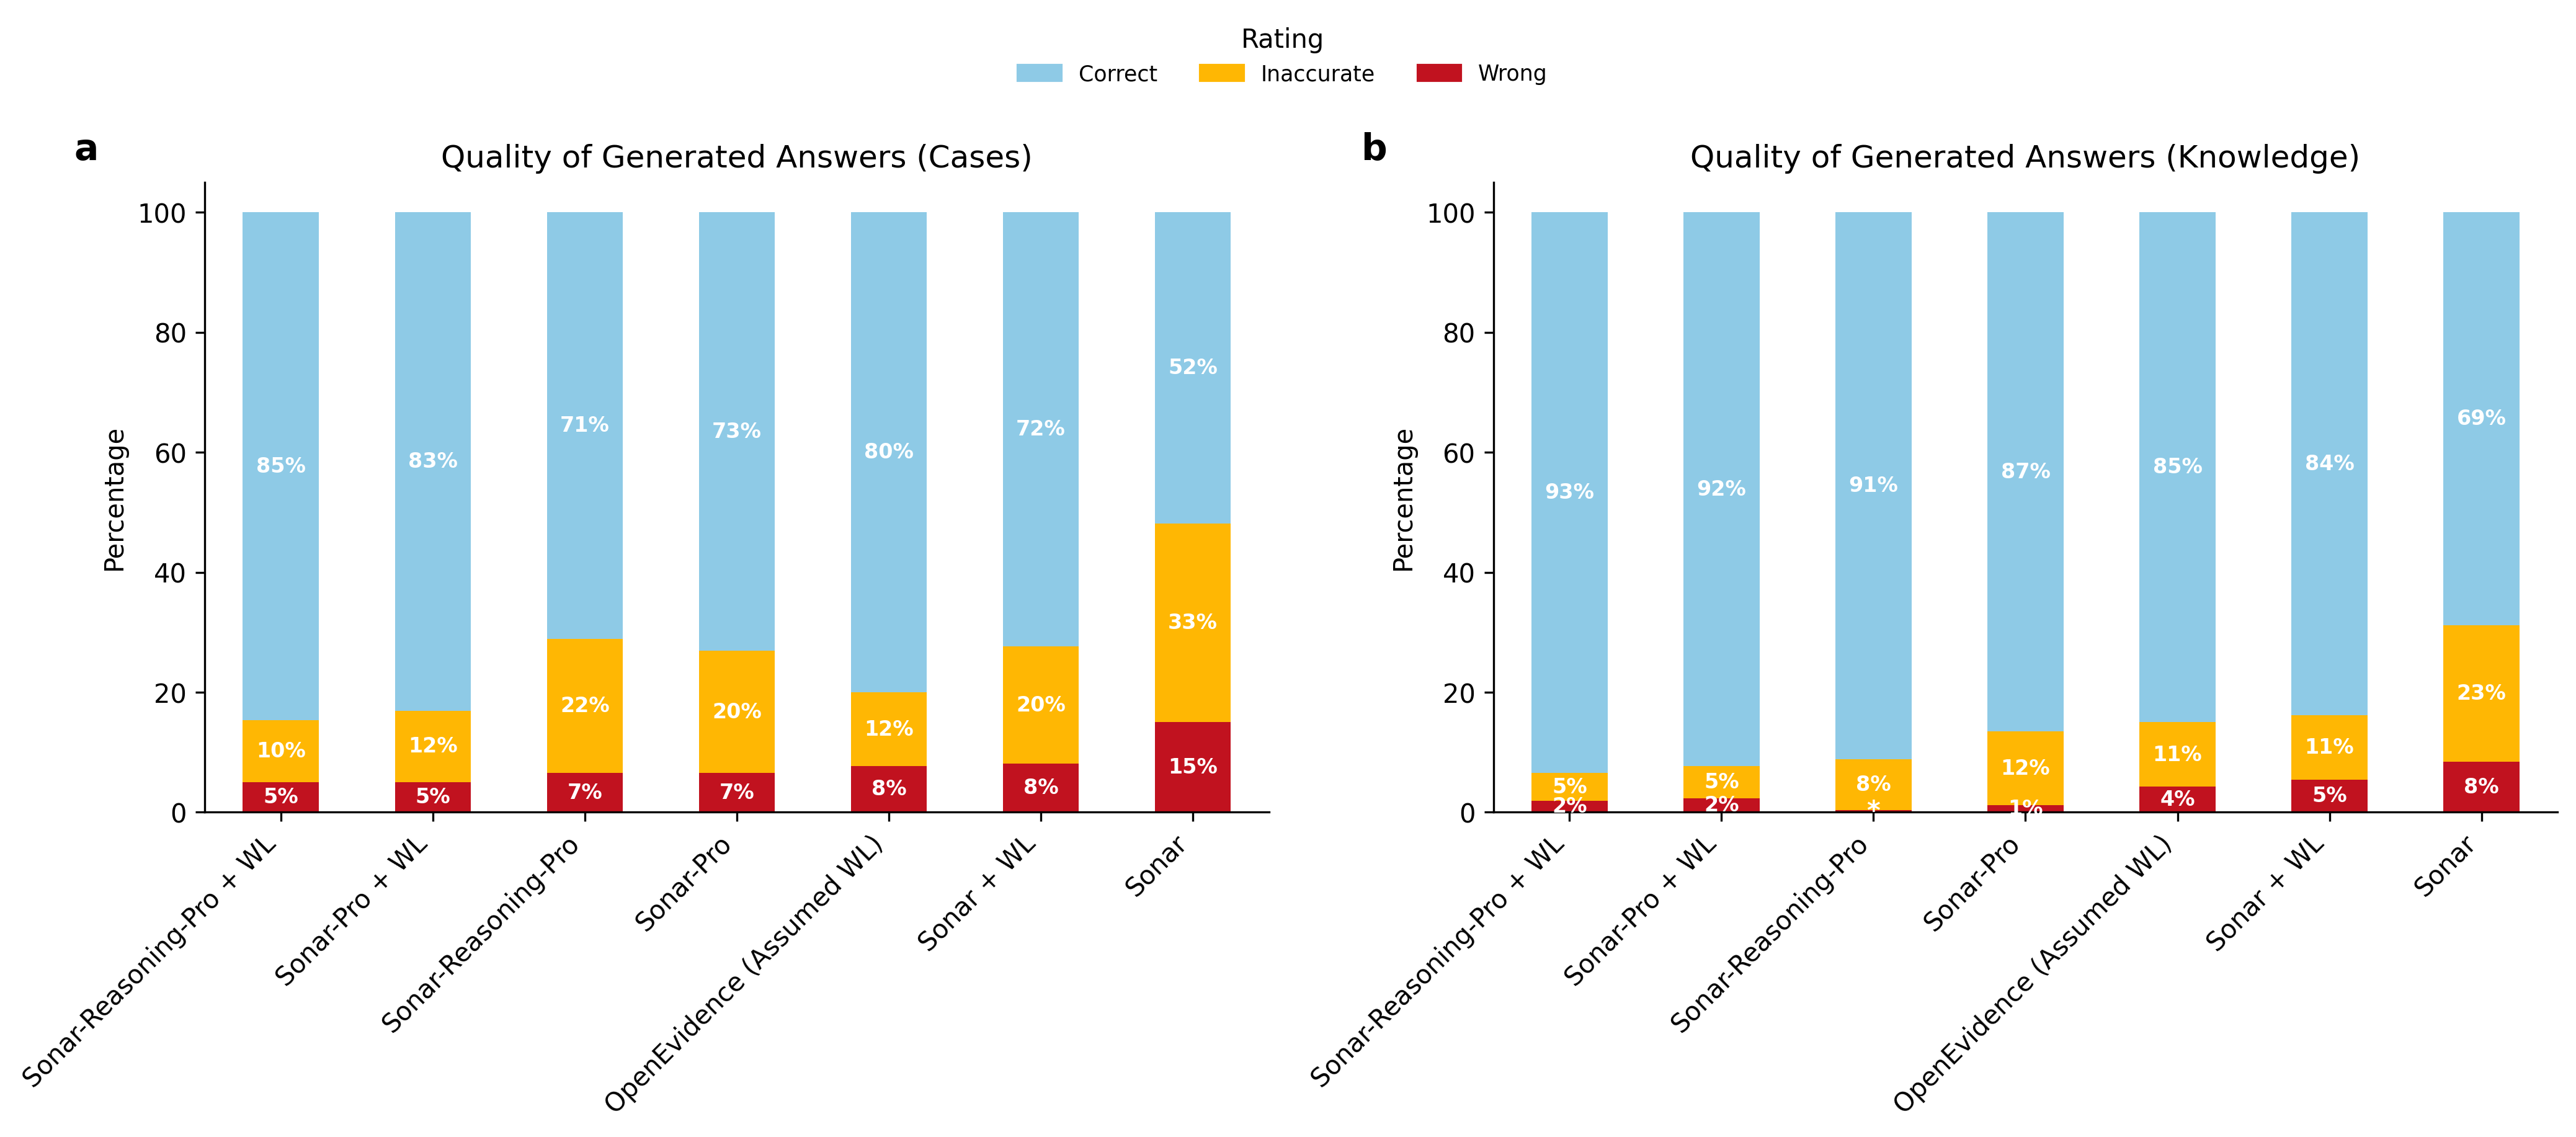

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data by Type
case_data = data[data["Type"] == "Case"]
knowledge_data = data[data["Type"] == "Knowledge"]

# Helper to format percent labels
def custom_label_func(labels):
    return [f'{label:.0f}%' if float(label) > 0 else '' for label in labels]

# Colors for ratings
t_colors = {
    'Correct': '#8ecae6',
    'Inaccurate': '#ffb703',
    'Wrong': '#c1121f'
}

# Calculate percentage distributions
rating_counts_case = (
    case_data
    .groupby('model_category')['Final Rating']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    * 100
)
rating_counts_know = (
    knowledge_data
    .groupby('model_category')['Final Rating']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    * 100
)

# Sort models by 'Correct' in knowledge set and reindex both
sorted_models = rating_counts_know.sort_values('Correct', ascending=False).index
rating_counts_case = rating_counts_case.reindex(index=sorted_models)
rating_counts_know = rating_counts_know.reindex(index=sorted_models)

# Create side-by-side subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), dpi=300)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Plot for Cases
a = axes[0]
bars_a = rating_counts_case[['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar', stacked=True,
    color=[t_colors['Wrong'], t_colors['Inaccurate'], t_colors['Correct']],
    ax=a
)
for container in bars_a.containers:
    heights = [rect.get_height() for rect in container]
    labels = custom_label_func(heights)
    for rect, label in zip(container, labels):
        h = rect.get_height()
        x = rect.get_x() + rect.get_width() / 2
        y = rect.get_y() + (h / 2 if h > 1 else h / 4)
        if h > 1:
            a.text(x, y, label, ha='center', va='center', fontsize=8, weight='bold', color='white')
        elif h > 0:
            a.text(x, y, '*', ha='center', va='center', fontsize=10, weight='bold', color='white')

a.text(-0.1, 1.08, 'a', transform=a.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
a.set_title('Quality of Generated Answers (Cases)')
a.set_ylabel('Percentage')
a.set_xlabel('')
a.set_xticklabels(sorted_models, rotation=45, ha='right')
a.legend([], frameon=False)

# Plot for Knowledge
b = axes[1]
bars_b = rating_counts_know[['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar', stacked=True,
    color=[t_colors['Wrong'], t_colors['Inaccurate'], t_colors['Correct']],
    ax=b
)
for container in bars_b.containers:
    heights = [rect.get_height() for rect in container]
    labels = custom_label_func(heights)
    for rect, label in zip(container, labels):
        h = rect.get_height()
        x = rect.get_x() + rect.get_width() / 2
        y = rect.get_y() + (h / 2 if h > 1 else h / 4)
        if h > 1:
            b.text(x, y, label, ha='center', va='center', fontsize=8, weight='bold', color='white')
        elif h > 0:
            b.text(x, y, '*', ha='center', va='center', fontsize=10, weight='bold', color='white')

b.text(-0.1, 1.08, 'b', transform=b.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
b.set_title('Quality of Generated Answers (Knowledge)')
b.set_ylabel('Percentage')
b.set_xlabel('')
b.set_xticklabels(sorted_models, rotation=45, ha='right')
b.legend([], frameon=False)

# Common legend for ratings placed above the plots
date_legend = [plt.Rectangle((0, 0), 1, 1, color=t_colors[label], label=label) for label in ['Correct', 'Inaccurate', 'Wrong']]
fig.legend(
    handles=date_legend,
    title='Rating',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=3,
    fontsize='small',
    frameon=False
)

# Final layout and saving
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Visualizations/Fig_Quality_Case_Know.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
data.to_excel("data_preprocessed.xlsx")

In [13]:
def format_p_value(p):
    if p < 0.001:
        return "P<.001"
    elif p < 0.01:
        return f"P={p:.3f}"
    elif p >= 0.99:
        return "P>.99"
    else:
        return f"P={p:.3f}"


In [14]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multitest import multipletests


# Define the encoding for ordinal categories
rating_mapping = {'Correct': 2, 'Inaccurate': 1, 'Wrong': 0}
data['rating_encoded'] = data['Final Rating'].map(rating_mapping)

models = data['model_category'].unique()

results = []
odds_ratios = []
for model in models:
    # Filter for this specific model
    subset = data[data['model_category'] == model]
    
    # Crosstab: Rows = Type (Case vs. Knowledge), Columns = Final Rating
    contingency_table = pd.crosstab(subset['Type'], subset['Final Rating'])

    # Expand data for ordinal logistic regression
    expanded_data = pd.DataFrame({
        'Type': subset['Type'].values,
        'Rating': subset['Final Rating'].map(rating_mapping),
    })

    # Prepare dummy variables for ordinal logistic regression
    expanded_data['Rating'] = pd.Categorical(
        expanded_data['Rating'], categories=[0, 1, 2], ordered=True
    )

    # Fit ordinal logistic regression model
    try:
        ord_model = OrderedModel(
            expanded_data['Rating'], 
            pd.get_dummies(expanded_data['Type'], drop_first=True), 
            distr='logit'
        )
        result = ord_model.fit(disp=False)
        p_value = result.pvalues[0]
        odds_ratio = np.exp(result.params[0])
        conf_int = np.exp(result.conf_int().loc[result.params.index[0]])
        direction = 'Increase' if odds_ratio < 1 else 'Decrease' if odds_ratio > 1 else 'No Effect'
        results.append((model, p_value))
        odds_ratios.append((model, odds_ratio, conf_int[0], conf_int[1], direction))
    except Exception as e:
        results.append((model, None))
        odds_ratios.append((model, None, None, None, None))

# Ensure there are valid results before unpacking
if any(r[1] is not None for r in results):
    model_names, pvals = zip(*[(r[0], r[1]) for r in results if r[1] is not None])
    reject, pvals_corrected, _, _ = multipletests(pvals, method='holm')
else:
    model_names, pvals, reject, pvals_corrected = [], [], [], []

from docx import Document
from docx.shared import Pt
from docx.oxml.ns import qn

# Helper to write into a cell with proper font

def set_cell_text(cell, text, bold=False, font_size=12):
    para = cell.paragraphs[0]
    run = para.add_run(str(text))
    run.bold = bold
    run.font.name = 'Times New Roman'
    run._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
    run.font.size = Pt(font_size)


# Section 1: Ordinal Logistic Regression Results by Model
doc1 = Document()
# Set default style to Times New Roman 12 pt
style = doc1.styles['Normal']
style.font.name = 'Times New Roman'
style._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
style.font.size = Pt(12)

doc1.add_heading('Ordinal Logistic Regression Results by Model', level=1)
doc1.add_paragraph(
    "Note: Odds Ratios represent the likelihood of higher performance "
    "('Correct' > 'Inaccurate' > 'Wrong') for 'Knowledge' relative to 'Case'.",
    style='Normal'
)

# Table setup
header = ['Model', 'P-value (Original)', 'P-value (Adjusted)', 'Significant?', 'Odds Ratio', '95% CI Lower', '95% CI Upper']
table1 = doc1.add_table(rows=1, cols=len(header))
table1.style = 'Table Grid'
# Header row
for idx, col_name in enumerate(header):
    set_cell_text(table1.rows[0].cells[idx], col_name, bold=True)

# Populate rows
for mn, original_p, corrected_p, rj, odds_data in zip(model_names, pvals, pvals_corrected, reject, odds_ratios):
    cells = table1.add_row().cells
    set_cell_text(cells[0], mn)
    set_cell_text(cells[1], format_p_value(original_p) if original_p is not None else 'N/A')
    set_cell_text(cells[2], format_p_value(corrected_p) if corrected_p is not None else 'N/A')
    set_cell_text(cells[3], 'Yes' if rj else 'No')
    set_cell_text(cells[4], f"{odds_data[1]:.4g}" if odds_data[1] is not None else 'N/A')
    set_cell_text(cells[5], f"{odds_data[2]:.4g}" if odds_data[2] is not None else 'N/A')
    set_cell_text(cells[6], f"{odds_data[3]:.4g}" if odds_data[3] is not None else 'N/A')

# Save document
output_path1 = 'Results/ordinal_logistic_results.docx'
doc1.save(output_path1)
print(f"📄 Word file saved to: {output_path1}")

📄 Word file saved to: Results/ordinal_logistic_results.docx


/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_14629/1532313670.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = result.pvalues[0]
/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_14629/1532313670.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratio = np.exp(result.params[0])
/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_14629/1532313670.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_14629/2856628192.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(change_counts.index, rotation=45, ha='right')


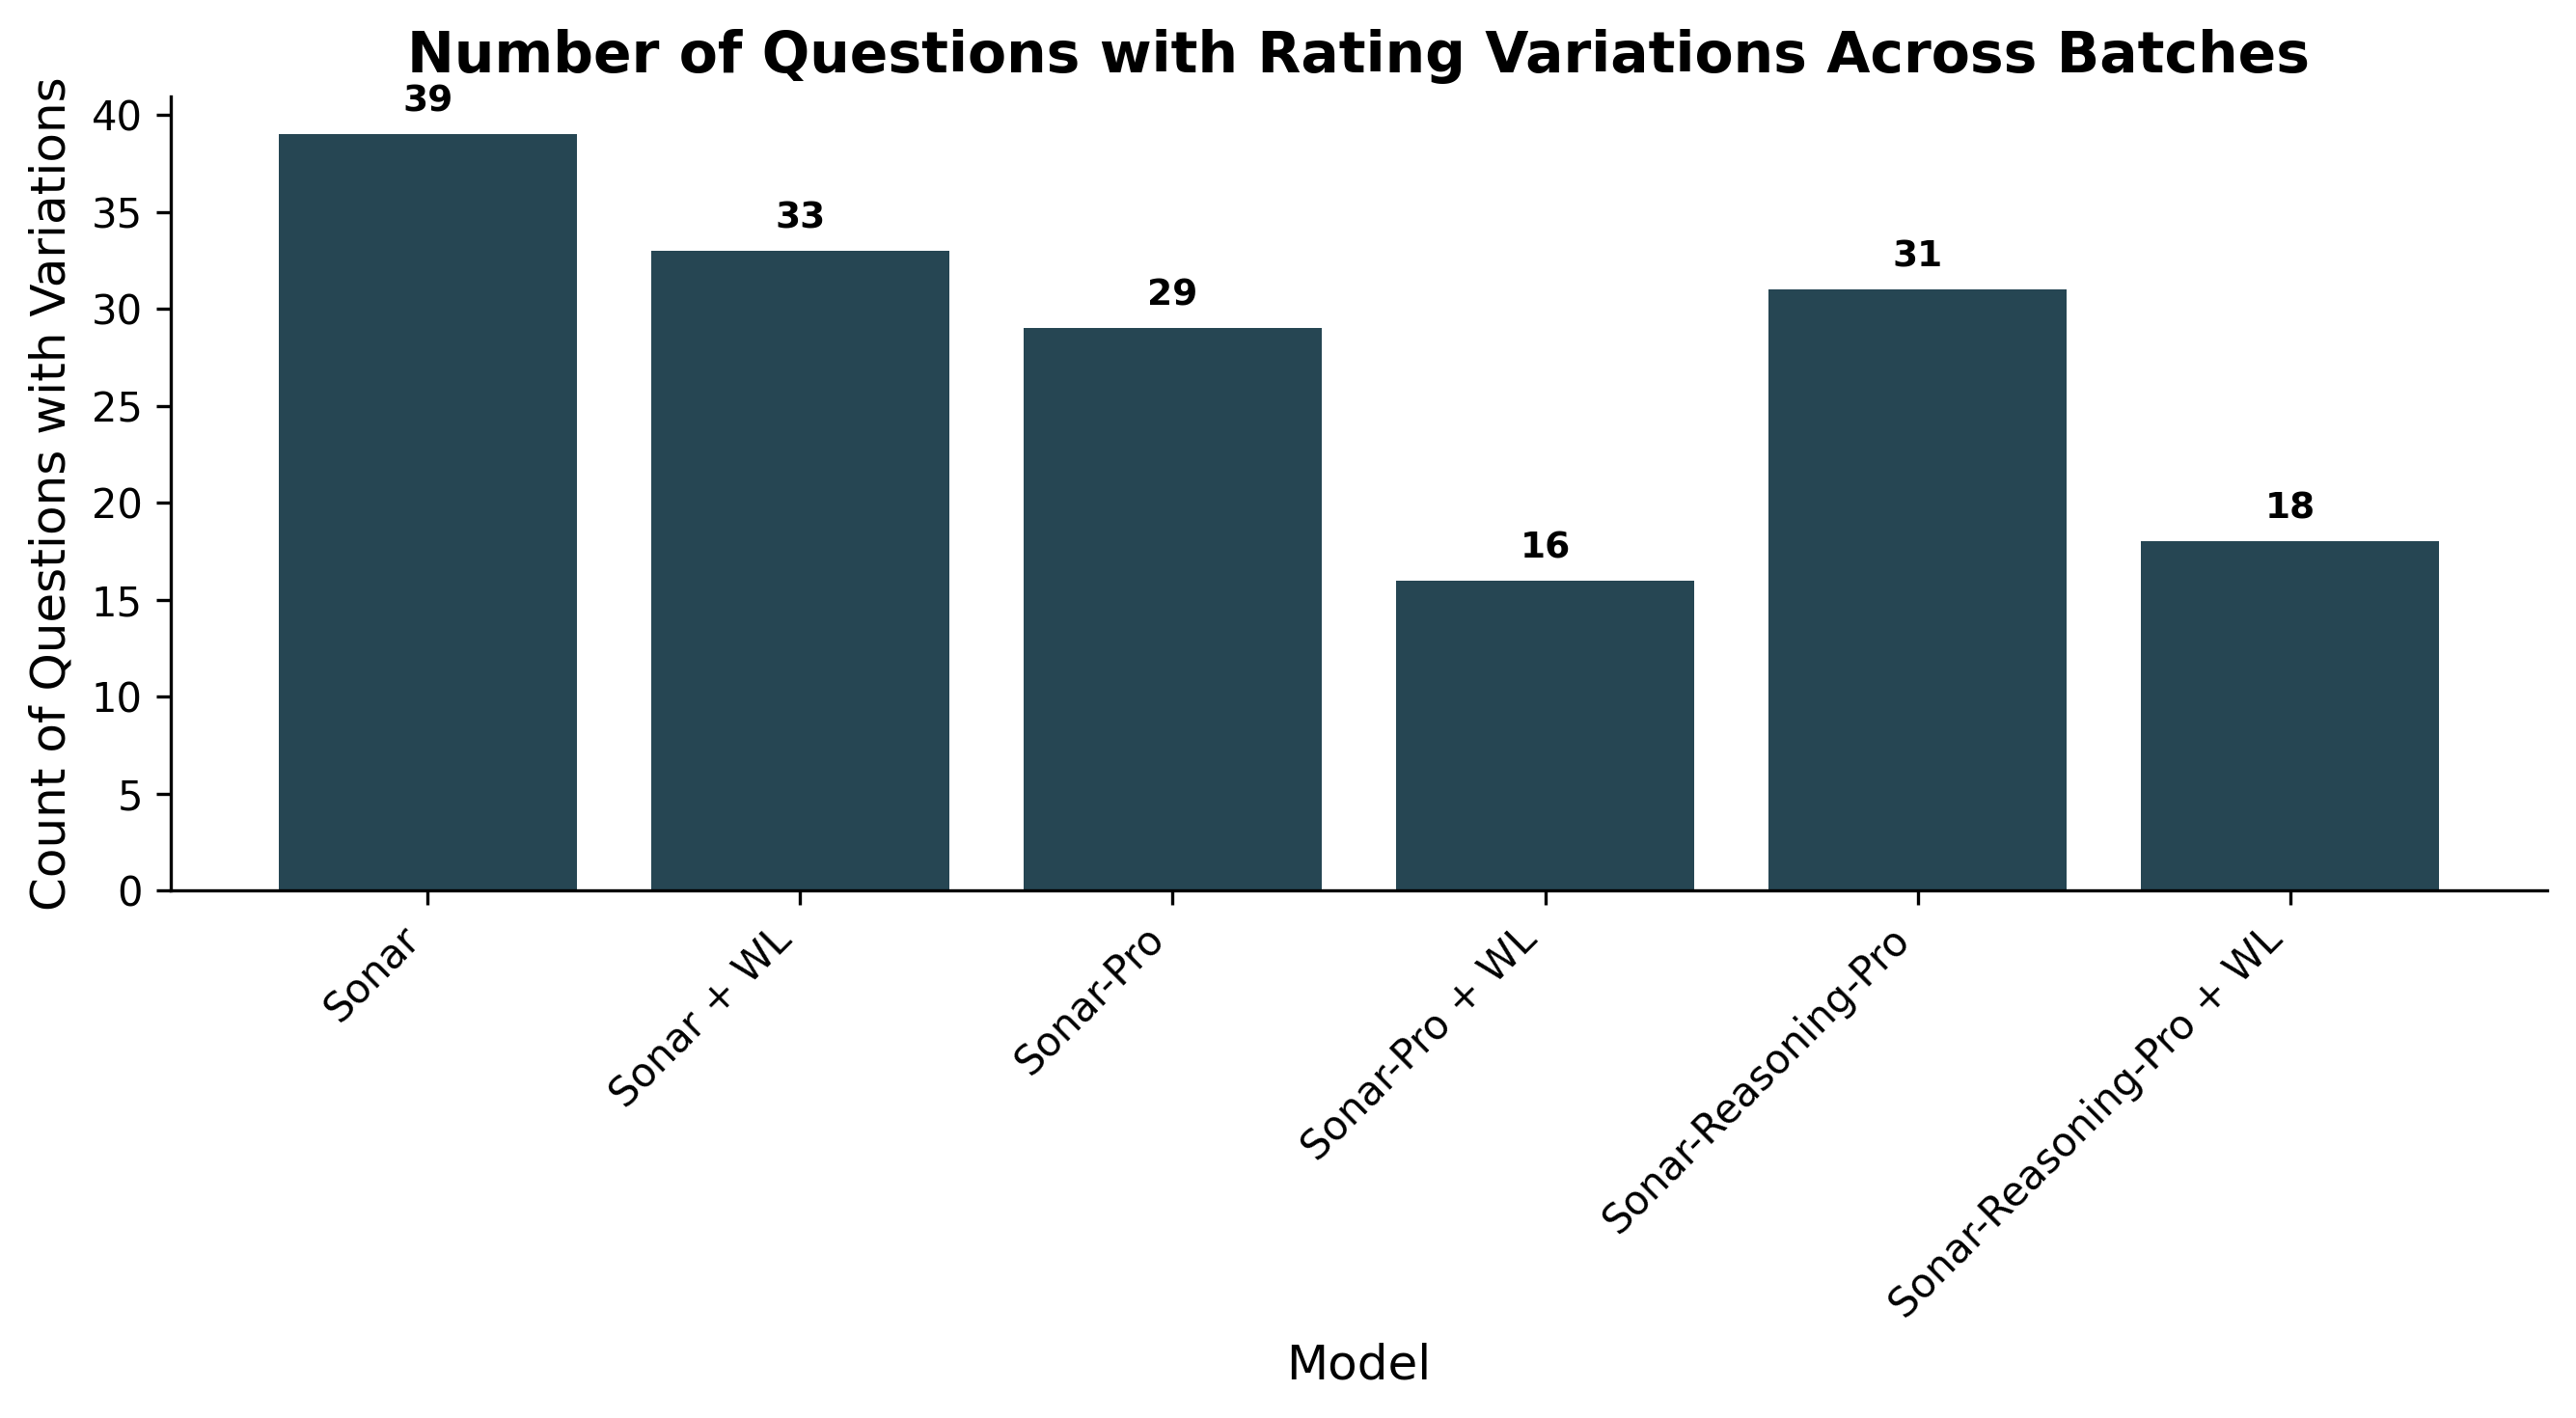

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for models containing 'Son'
son_data = data[data['model_category'].str.contains('Son', na=False)]

variation_flags = (
    son_data
    .groupby(['model_category', 'Question Number'])['Final Rating']
    .nunique()
    .gt(1)
    .reset_index(name='has_variation')
)
change_counts = (
    variation_flags
    .groupby('model_category')['has_variation']
    .sum()
)

# Plot publication-ready bar chart
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

bars = ax.bar(
    change_counts.index,
    change_counts.values,
    color='#264653'
)

# Annotate each bar with count label
max_count = change_counts.max()
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + max_count * 0.02,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9,
        weight='bold'
    )

# Formatting
ax.set_title('Number of Questions with Rating Variations Across Batches', fontsize=14, weight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Count of Questions with Variations', fontsize=12)
ax.set_xticklabels(change_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Visualizations/Sonar_models_rating_variations.png', dpi=300)
plt.show()


## Significance checks

In [16]:

import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare, wilcoxon
import itertools
from statsmodels.stats.multitest import multipletests
import docx


In [17]:


# Define explicit encoding for the rating
rating_mapping = {'Correct': 2, 'Inaccurate': 1, 'Wrong': 0}
data['rating_encoded'] = data['Final Rating'].map(rating_mapping)

# Aggregate duplicates using `batch`, `Model`, and `Question Number` as unique identifiers
cleaned_data = data.groupby(['batch', 'model_category', 'Question Number'], as_index=False)['rating_encoded'].median()

# Further aggregate to ensure uniqueness in `Question Number` and `Model`
# Using pandas.Series.mode
final_cleaned_data = cleaned_data.groupby(['Question Number', 'model_category'], as_index=False)['rating_encoded'].agg(lambda x: x.mode().iloc[0])


# Pivot the data after resolving all duplicates
model_data = final_cleaned_data.pivot(index='Question Number', columns='model_category', values='rating_encoded')

# Count the number of "Correct" ratings for each model
correct_counts = final_cleaned_data[final_cleaned_data['rating_encoded'] == 2].groupby('model_category')['rating_encoded'].count()

# Sort the models by the count of "Correct" ratings in descending order
sorted_models = correct_counts.sort_values(ascending=False).index.tolist()

# Reorder the DataFrame columns based on the sorted models
model_data = model_data[sorted_models]

# Explode the data correctly for each column
exploded_data = pd.DataFrame({
    col: model_data[col].explode() for col in model_data.columns
})


# Perform the Friedman Test
friedman_stat, friedman_p = friedmanchisquare(*[exploded_data[col].dropna() for col in exploded_data.columns])

# Generate all pairwise combinations of models for post-hoc analysis
model_pairs = list(itertools.combinations(exploded_data.columns, 2))
p_values = []
indices = []

for pair in model_pairs:
    # Drop NaN values for the Wilcoxon test
    ratings1 = exploded_data[pair[0]].dropna()
    ratings2 = exploded_data[pair[1]].dropna()
    try:
        stat, p_value = wilcoxon(ratings1, ratings2)
    except ValueError:
        p_value = np.nan  # Handle cases with insufficient data for the Wilcoxon test
    indices.append(pair)
    p_values.append(p_value)

# Adjust for multiple comparisons using Holm correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

# Create a DataFrame to hold the post-hoc results with separated model pair columns
results_df = pd.DataFrame({
    'Model 1': [pair[0] for pair in indices],
    'Model 2': [pair[1] for pair in indices],
    'Original P-Value': [format_p_value(p) if not pd.isna(p) else "N/A" for p in p_values],
    'P-Value Adjusted': [format_p_value(p) if not pd.isna(p) else "N/A" for p in pvals_corrected],
    'Significantly Different': ['Yes' if flag else 'No' for flag in reject]
})


print(friedman_stat, friedman_p)
results_df
     

73.72842639593891 7.011425434081272e-14


,Model 1,Model 2,Original P-Value,P-Value Adjusted,Significantly Different
0,Sonar-Reasoning-Pro + WL,Sonar-Pro + WL,P=0.317,P>.99,No
1,Sonar-Reasoning-Pro + WL,OpenEvidence (Assumed WL),P=0.064,P=0.706,No
2,Sonar-Reasoning-Pro + WL,Sonar-Pro,P=0.032,P=0.380,No
3,Sonar-Reasoning-Pro + WL,Sonar-Reasoning-Pro,P=0.013,P=0.169,No
4,Sonar-Reasoning-Pro + WL,Sonar + WL,P<.001,P=0.009,Yes
5,Sonar-Reasoning-Pro + WL,Sonar,P<.001,P<.001,Yes
6,Sonar-Pro + WL,OpenEvidence (Assumed WL),P=0.266,P>.99,No
7,Sonar-Pro + WL,Sonar-Pro,P=0.139,P>.99,No
8,Sonar-Pro + WL,Sonar-Reasoning-Pro,P=0.147,P>.99,No
9,Sonar-Pro + WL,Sonar + WL,P=0.005,P=0.066,No


In [18]:
# Export as Word
from docx import Document
from docx.shared import Pt, Inches
from docx.oxml.ns import qn

# Helper to write into a cell with proper font
def set_cell_text(cell, text, bold=False, font_size=12):
    para = cell.paragraphs[0]
    run = para.add_run(str(text))
    run.bold = bold
    run.font.name = 'Times New Roman'
    run._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
    run.font.size = Pt(font_size)

# — Create the document
doc = Document()
# Set default style to Times New Roman 12 pt
style = doc.styles['Normal']
style.font.name = 'Times New Roman'
style._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
style.font.size = Pt(12)

# — Title and Friedman summary
doc.add_heading('Friedman Test & Post-hoc Wilcoxon Results', level=1)
doc.add_paragraph(
    f'Friedman χ² = {friedman_stat:.3f}, p = {friedman_p:.3e}', 
    style='Normal'
)

# — Build the table
headers = list(results_df.columns)
table = doc.add_table(rows=1, cols=len(headers))
table.style = 'Table Grid'
# Header row
for idx, col in enumerate(headers):
    set_cell_text(table.rows[0].cells[idx], col, bold=True)
# Data rows
for _, row in results_df.iterrows():
    cells = table.add_row().cells
    for idx, col in enumerate(headers):
        set_cell_text(cells[idx], row[col])

# — Save
output_path = 'results/Friedman_posthoc_results.docx'
doc.save(output_path)
print(f'📄 Word file saved to: {output_path}')


📄 Word file saved to: results/Friedman_posthoc_results.docx


/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_14629/705717469.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = p_matrix.copy().applymap(lambda x: format_p_value(x))


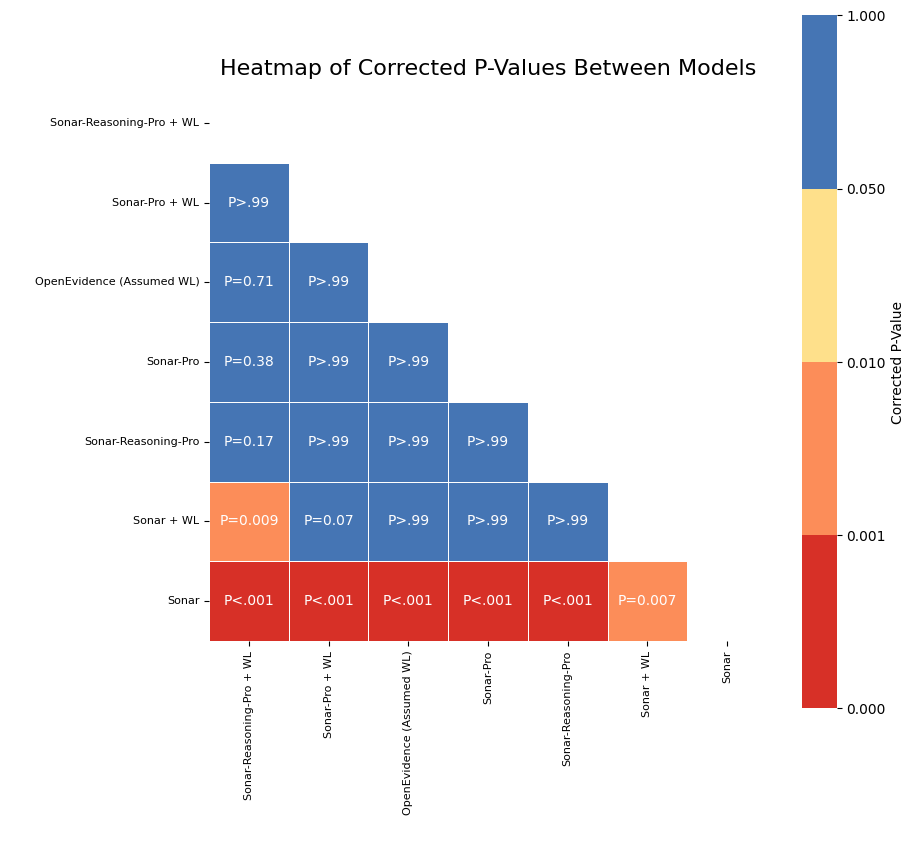

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the custom formatting function
def format_p_value(p):
    if pd.isna(p):  # Handle NaN values
        return ""
    elif p < 0.001:
        return "P<.001"
    elif p < 0.01:
        return f"P={p:.3f}"
    elif p >= 0.99:
        return "P>.99"
    else:
        return f"P={p:.2f}"

# Create a list of all models (assuming exploded_data is already defined)
models = exploded_data.columns.tolist()

# Initialize an empty matrix for p-values
p_matrix = pd.DataFrame(index=models, columns=models, dtype=float)

# Populate the matrix with p-values
for (model1, model2), p_value in zip(indices, pvals_corrected):
    p_matrix.loc[model1, model2] = p_value
    p_matrix.loc[model2, model1] = p_value  # Ensure symmetry

# Fill diagonal with NaN (no self-comparisons)
np.fill_diagonal(p_matrix.values, np.nan)

# Create an annotation matrix with formatted p-values
annot_matrix = p_matrix.copy().applymap(lambda x: format_p_value(x))

# Define a custom colormap and bounds
custom_cmap = ListedColormap(['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4'])
bounds = [0, 0.001, 0.01, 0.05, 1]  # Boundaries for significance levels
norm = BoundaryNorm(bounds, custom_cmap.N)

# Plot the heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(
    p_matrix,
    annot=annot_matrix,  # Pass the formatted annotation matrix
    fmt="",  # No additional formatting required
    cmap=custom_cmap,
    cbar_kws={'label': 'Corrected P-Value'},
    mask=np.triu(np.ones_like(p_matrix, dtype=bool)),  # Mask upper triangle
    linewidths=0.5,
    norm=norm,
    square=True
)

# Add titles and labels
plt.title('Heatmap of Corrected P-Values Between Models', fontsize=16)
plt.xlabel(' ', fontsize=14)
plt.ylabel(' ', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Save the heatmap
plt.savefig('Visualizations/P_Matrix.png', dpi=300, bbox_inches='tight')
plt.savefig('Visualizations/P_Matrix.eps', dpi=300, bbox_inches='tight')
plt.savefig('Visualizations/P_Matrix.svg', dpi=300, bbox_inches='tight')

plt.show()

# Analysis of WL vs No-WL

In [20]:
from scipy.stats import wilcoxon


    
    
# 1) Flag WL vs. non-WL, and drop OpenEvidence
df = final_cleaned_data.copy()
df = df[df['model_category'] != 'OpenEvidence (Assumed WL)']
df['is_wl'] = df['model_category'].str.contains(r'\+ WL')

# 2) Overall paired by question: mean rating across all WL vs. all non-WL
pivot = (df
         .pivot_table(index='Question Number',
                      columns='is_wl',
                      values='rating_encoded',
                      aggfunc='mean')
         .dropna())
stat_all, p_all = wilcoxon(pivot[True], pivot[False])
print(f"Overall WL vs. non-WL: stat={stat_all:.2f}, p={p_all:.4f}")

# 3) Sub-analysis per base model
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

base_models = ['Sonar', 'Sonar-Pro', 'Sonar-Reasoning-Pro']
raw_ps = []

# 1) Collect raw p-values
for base in base_models:
    wl = f"{base} + WL"
    tmp = model_data[[wl, base]].dropna()
    stat, p = wilcoxon(tmp[wl], tmp[base])
    raw_ps.append(p)

# 2) Apply Holm correction across the three tests
_, p_corrected, _, _ = multipletests(raw_ps, alpha=0.05, method='holm')

# 3) Print a table of results
for base, p_raw, p_corr in zip(base_models, raw_ps, p_corrected):
    print(f"{base}: raw p = {p_raw:.4f}, "
          f"Holm p = {p_corr:.4f}, "
          f"significant? {'Yes' if p_corr < 0.05 else 'No'}")

Overall WL vs. non-WL: stat=346.50, p=0.0000
Sonar: raw p = 0.0004, Holm p = 0.0013, significant? Yes
Sonar-Pro: raw p = 0.1391, Holm p = 0.1391, significant? No
Sonar-Reasoning-Pro: raw p = 0.0130, Holm p = 0.0260, significant? Yes


In [24]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from itertools import islice, cycle

def format_p_value_graph(p):
    if pd.isna(p):  # Handle NaN values
        return ""
    elif p < 0.001:
        return "P<.001"
    elif p < 0.01:
        return f"P={p:.3f}"
    elif p >= 0.99:
        return "P>.99"
    else:
        return f"P={p:.3f}"
    
def format_corr_p_value_graph(p):
    if pd.isna(p):  # Handle NaN values
        return ""
    elif p < 0.001:
        return "Adj. P<.001"
    elif p < 0.01:
        return f"Adj. P={p:.3f}"
    elif p >= 0.99:
        return "Adj. P>.99"
    else:
        return f"Adj. P={p:.3f}"
# -------------------------------------------------
# Color-blind-safe palette & rating colors
# -------------------------------------------------
CB = sns.color_palette("colorblind")
# Updated rating colors (Wrong, Inaccurate, Correct)
RATING_COL = {
    0: "#c1121f",  # Wrong
    1: "#ffb703",  # Inaccurate
    2: "#8ecae6"   # Correct
}

# -------------------------------------------------
# Helpers
# -------------------------------------------------

def add_wl_flag(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out = out[out["model_category"] != "OpenEvidence (Assumed WL)"]
    if "is_wl" not in out.columns:
        out["is_wl"] = out["model_category"].str.contains(r"\+\s*WL")
    return out


def _agg_question_model(df: pd.DataFrame) -> pd.DataFrame:
    # average duplicates of Question×model
    return df.groupby(
        ["Question Number", "model_category", "is_wl"], as_index=False
    )["rating_encoded"].mean()


def _cliffs_delta_paired(diffs: np.ndarray) -> float:
    """Cliff's δ for paired differences."""
    n_pos = np.sum(diffs > 0)
    n_neg = np.sum(diffs < 0)
    return (n_pos - n_neg) / diffs.size


def _boot_ci(arr: np.ndarray, n: int = 5000, ci: float = 95, *, stat="mean") -> tuple[float, float]:
    rng = np.random.default_rng(0)
    if stat == "mean":
        boots = rng.choice(arr, (n, arr.size), replace=True).mean(axis=1)
    elif stat == "median":
        boots = np.median(rng.choice(arr, (n, arr.size), replace=True), axis=1)
    elif stat == "delta":
        boots = np.array([_cliffs_delta_paired(b) for b in rng.choice(arr, (n, arr.size), replace=True)])
    else:
        raise ValueError("stat must be 'mean', 'median', or 'delta'")
    low, high = np.percentile(boots, [(100 - ci) / 2, 100 - (100 - ci) / 2])
    return low, high


# -------------------------------------------------
# Figure-wide labelling utilities
# -------------------------------------------------

def _label_subplots(fig: plt.Figure, *,
                    start: str = "a",
                    offset: tuple[float, float] = (-0.1, 1.25)) -> None:
    """Annotate every Axes in *fig* with sequential letters (a, b, …) in the upper‐left corner.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure whose axes will be labelled.
    start : str, default "a"
        Starting character for labelling.
    offset : (float, float), default (0.03, 0.97)
        Position in Axes fraction coordinates where the label is placed.
    """
    letters = cycle("abcdefghijklmnopqrstuvwxyz")
    # Advance generator to the requested start letter
    for _ in range(ord(start.lower()) - ord("a")):
        next(letters)
    for ax, lab in zip(fig.axes, islice(letters, len(fig.axes))):
        ax.text(
            offset[0], offset[1], lab+")",
            transform=ax.transAxes,
            ha="left",   # align to left edge
            va="top",
            fontsize=11,
            fontweight="bold"
        )


# -------------------------------------------------
# Gardner–Altman plot
# -------------------------------------------------

def gardner_altman(
    df_pair: pd.DataFrame,
    *,
    ax_l: plt.Axes,
    ax_r: plt.Axes,
    label_l: str = "Baseline",
    label_r: str = "WL"
) -> None:
    # columns order: first=baseline, second=WL
    cols = list(df_pair.columns)
    col_l, col_r = cols[0], cols[1]
    diffs = df_pair[col_r] - df_pair[col_l]

    # left: paired lines + scatter
    for _, row in df_pair.iterrows():
        ax_l.plot([0, 1], [row[col_l], row[col_r]], color="grey", alpha=0.5, lw=0.7)
    jitter = np.random.uniform(-0.05, 0.05, size=len(df_pair))
    ax_l.scatter(jitter, df_pair[col_l], c=CB[4], s=20, label=label_l)
    ax_l.scatter(1 + jitter, df_pair[col_r], c=CB[1], s=20, label=label_r)
    ax_l.set_xticks([0, 1])
    ax_l.set_xticklabels([label_l, label_r], rotation=15, ha='right')
    ax_l.set_xlim(-0.4, 1.4)
    sns.despine(ax=ax_l)

    # right: distribution + bootstrap CI
    ax_r.axvline(0, linestyle="--", color="grey", lw=0.8)
    jitter_y = np.random.uniform(-0.03, 0.03, size=len(diffs))
    ax_r.scatter(diffs, jitter_y, c=CB[1], s=20, alpha=0.7)
    mean_d = diffs.mean()
    lo, hi = _boot_ci(diffs.to_numpy())
    ax_r.errorbar(
        mean_d,
        0,
        xerr=[[mean_d - lo], [hi - mean_d]],
        fmt="D",
        capsize=4,
        color="black"
    )
    xlabel = f"{label_r} - {label_l} (mean diff)"
    if len(xlabel) > 50:
        xlabel = xlabel.replace(" – ", " –\n")
    ax_r.set_xlabel(xlabel)
    ax_r.set_yticks([])
    ax_r.set_xlim(-2.25, 2.25)
    sns.despine(ax=ax_r, left=True)


# -------------------------------------------------
# Stacked ordinal distribution plot
# -------------------------------------------------

def stacked_ordinal(df: pd.DataFrame, *, ax: plt.Axes) -> None:
    dist = df.groupby(["is_wl", "rating_encoded"]).size().reset_index(name="count")
    dist["prop"] = dist.groupby("is_wl")["count"].transform(lambda x: x / x.sum())
    for wl_flag, grp in dist.groupby("is_wl"):
        bottom = 0.0
        for rate in [0, 1, 2]:
            row = grp[grp["rating_encoded"] == rate]
            if not row.empty:
                p = row["prop"].values[0]
                ax.barh(
                    "non-WL" if wl_flag else "WL",
                    p,
                    left=bottom,
                    color=RATING_COL[rate]
                )
                bottom += p
    ax.set_xlabel("Proportion of answers")
    ax.set_xlim(0, 1)
    ax.invert_yaxis()
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["non-WL", "WL"])
    # Legend — create patches to ensure correct colours
    handles = [plt.Rectangle((0, 0), 1, 1, color=RATING_COL[r]) for r in [0, 1, 2]]
    labels = ["Wrong (0)", "Inaccurate (1)", "Correct (2)"]
    ax.legend(handles, labels, title="Rating", loc="center left", bbox_to_anchor=(1, 0.5))
    sns.despine(ax=ax, left=True)


# -------------------------------------------------
# Forest plot by base model
# -------------------------------------------------

def forest_base(df: pd.DataFrame, *, ax: plt.Axes) -> None:
    df2 = add_wl_flag(df)
    agg = _agg_question_model(df2)
    bases = ["Sonar", "Sonar-Pro", "Sonar-Reasoning-Pro"]
    stats: list[dict] = []
    for base in bases:
        wl = f"{base} + WL"
        tmp = (
            agg[agg["model_category"].isin([base, wl])]
            .pivot(
                index="Question Number",
                columns="model_category",
                values="rating_encoded"
            )
            .dropna()
        )
        diffs = tmp[wl] - tmp[base]
        m = diffs.mean()
        lo, hi = _boot_ci(diffs.to_numpy())
        p_raw = wilcoxon(tmp[wl], tmp[base]).pvalue
        delta = _cliffs_delta_paired(diffs.to_numpy())

        stats.append({"base": base, "mean": m, "lo": lo, "hi": hi,"delta": delta, "p_raw": p_raw})
    raw_ps = [d["p_raw"] for d in stats]
    _, p_corr, _, _ = multipletests(raw_ps, method="holm")
    for d, pc in zip(stats, p_corr):
        d["p_corr"] = pc

    for i, d in enumerate(stats):
        ax.errorbar(
            d["mean"],
            i,
            xerr=[[d["mean"] - d["lo"]], [d["hi"] - d["mean"]]],
            fmt="o",
            capsize=4,
            color=CB[1]
        )
        ax.text(d["hi"] + 0.05, i, f"p={d['p_corr']:.3f}\nδ={d['delta']:.2f}", va="center", fontsize=8)

    ax.set_yticks(list(range(len(bases))))
    ax.set_yticklabels(bases)
    ax.axvline(0, linestyle="--", color="grey", lw=0.8)
    ax.set_xlabel("Mean paired diff")
    sns.despine(ax=ax)


# -------------------------------------------------
# Composite — overall
# -------------------------------------------------

def composite_overall(df: pd.DataFrame, savepath: str | None = None) -> plt.Figure:
    df2 = add_wl_flag(df)
    pair = (
        df2.pivot_table(
            index="Question Number",
            columns="is_wl",
            values="rating_encoded",
            aggfunc="mean"
        )
        .dropna()
    )
    fig = plt.figure(figsize=(7, 6))
    gs = GridSpec(2, 2, hspace=0.4, wspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    gardner_altman(pair, ax_l=ax1, ax_r=ax2)
    ax3 = fig.add_subplot(gs[1, 0])
    stacked_ordinal(df2, ax=ax3)
    ax4 = fig.add_subplot(gs[1, 1])
    forest_base(df2, ax=ax4)

    # — subplot labels
    _label_subplots(fig)

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig


# -------------------------------------------------
# Composite — by base model
# -------------------------------------------------

# -------------------------------------------------
# Composite — by base model (Δ + δ   |   p | p-corr)
# -------------------------------------------------

def composite_by_model(df: pd.DataFrame, savepath: str | None = None) -> plt.Figure:
    """Side-by-side GA, mean-diff, and ordinal-stack plots for each base model."""
    df2  = add_wl_flag(df)
    agg  = _agg_question_model(df2)
    bases = ["Sonar", "Sonar-Pro", "Sonar-Reasoning-Pro"]
    n     = len(bases)

    # ---------- pre-compute stats so we can Holm-adjust p-values ----------
    stats, pairs = [], {}
    for base in bases:
        wl   = f"{base} + WL"
        pair = (agg[agg["model_category"].isin([base, wl])]
                 .pivot(index="Question Number", columns="is_wl",
                        values="rating_encoded").dropna())
        diffs   = pair.iloc[:, 1] - pair.iloc[:, 0]
        m, (lo, hi) = diffs.mean(), _boot_ci(diffs.to_numpy())
        delta   = _cliffs_delta_paired(diffs.to_numpy())
        p_raw   = wilcoxon(pair.iloc[:, 1], pair.iloc[:, 0]).pvalue
        stats.append({"base": base, "mean": m, "lo": lo, "hi": hi,
                      "delta": delta, "p_raw": p_raw})
        pairs[base] = pair

    # Holm correction
    raw_ps  = [d["p_raw"] for d in stats]
    _, p_corr, _, _ = multipletests(raw_ps, method="holm")
    for d, pc in zip(stats, p_corr):
        d["p_corr"] = pc

    # ---------- plotting ----------
    fig = plt.figure(figsize=(10, 3.2 * n))
    gs  = GridSpec(n, 3, wspace=0.5, hspace=0.6)
    legend_done = False

    for i, d in enumerate(stats):
        base, m, lo, hi, delta = d["base"], d["mean"], d["lo"], d["hi"], d["delta"]
        p, p_adj = d["p_raw"], d["p_corr"]
        pair = pairs[base]
        wl   = f"{base} + WL"

        # Gardner–Altman
        ax_l = fig.add_subplot(gs[i, 0])
        ax_r = fig.add_subplot(gs[i, 1], sharey=ax_l)
        gardner_altman(pair, ax_l=ax_l, ax_r=ax_r, label_l=base, label_r=wl)
        ax_r.set_xlim(-2.25, 2.25)

        # two-line stats box
        line1 = f"Δ={m:.2f} [{lo:.2f},{hi:.2f}]  |  δ={delta:.2f}"
        line2 = f"{format_p_value_graph(p)}  |  {format_corr_p_value_graph(p_adj)}"
        ax_r.annotate(f"{line1}\n{line2}",
                      xy=(0.5, 0.5), xycoords='axes fraction', ha='center',
                      fontsize=10,
                      bbox=dict(boxstyle='round,pad=0.35',
                                fc='white', ec='black', lw=0.6))
        ax_l.set_title(f"{base}\nPaired means", fontsize=11)
        ax_r.set_title(f"{base}\nMean diffs", fontsize=11)

        # Ordinal distribution
        ax_o = fig.add_subplot(gs[i, 2])
        df_mod = df2[df2["model_category"].isin([base, wl])]
        stacked_ordinal(df_mod, ax=ax_o)
        ax_o.set_title(f"{base}\nOrdinal dist.", fontsize=11)
        if legend_done:
            ax_o.get_legend().remove()
        legend_done = True

    _label_subplots(fig)
    fig.tight_layout(pad=2.0)
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig


# -------------------------------------------------
# Example (comment or remove in production)
# -------------------------------------------------
# composite_by_model(data, "Visualizations/composite_by_model.png")


/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_14629/1831546330.py:139: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_l.scatter(jitter, df_pair[col_l], c=CB[4], s=20, label=label_l)
/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_14629/1831546330.py:140: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_l.scatter(1 + jitter, df_pair[col_r], c=CB[1], s=20, label=label_r)
/var/folders/l_/hnp4n5y13k3dbz

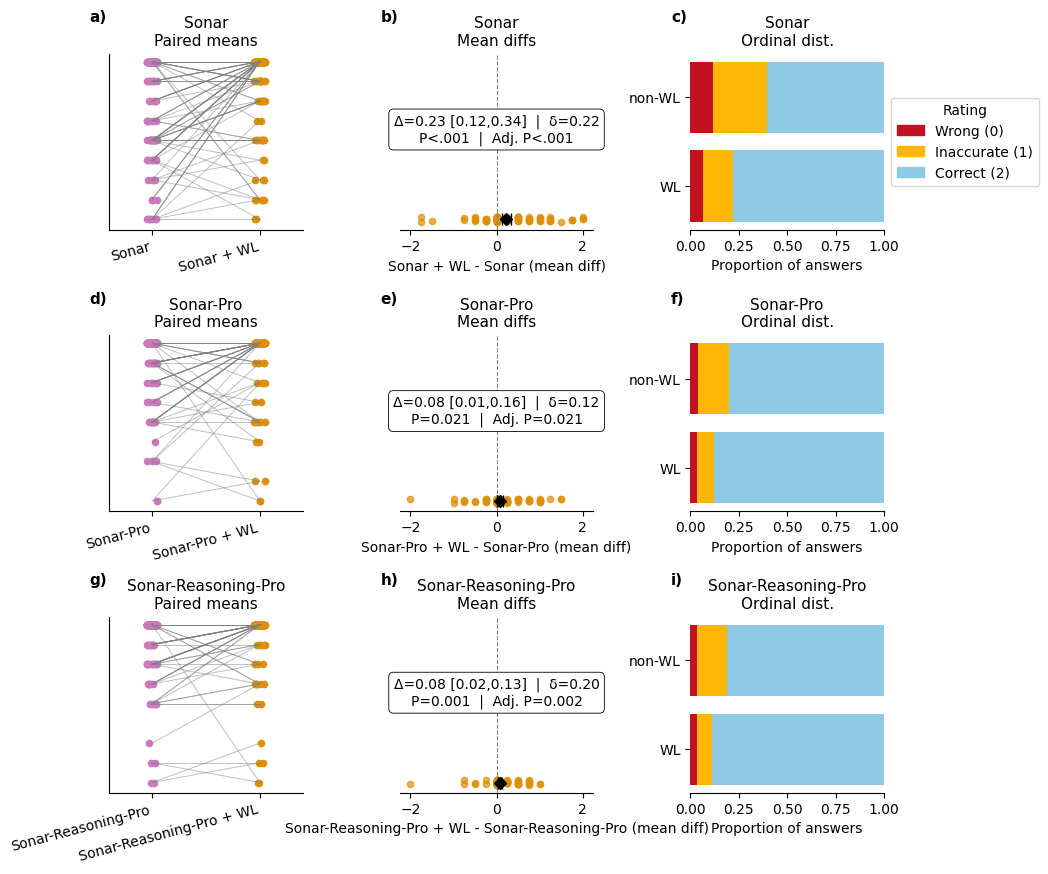

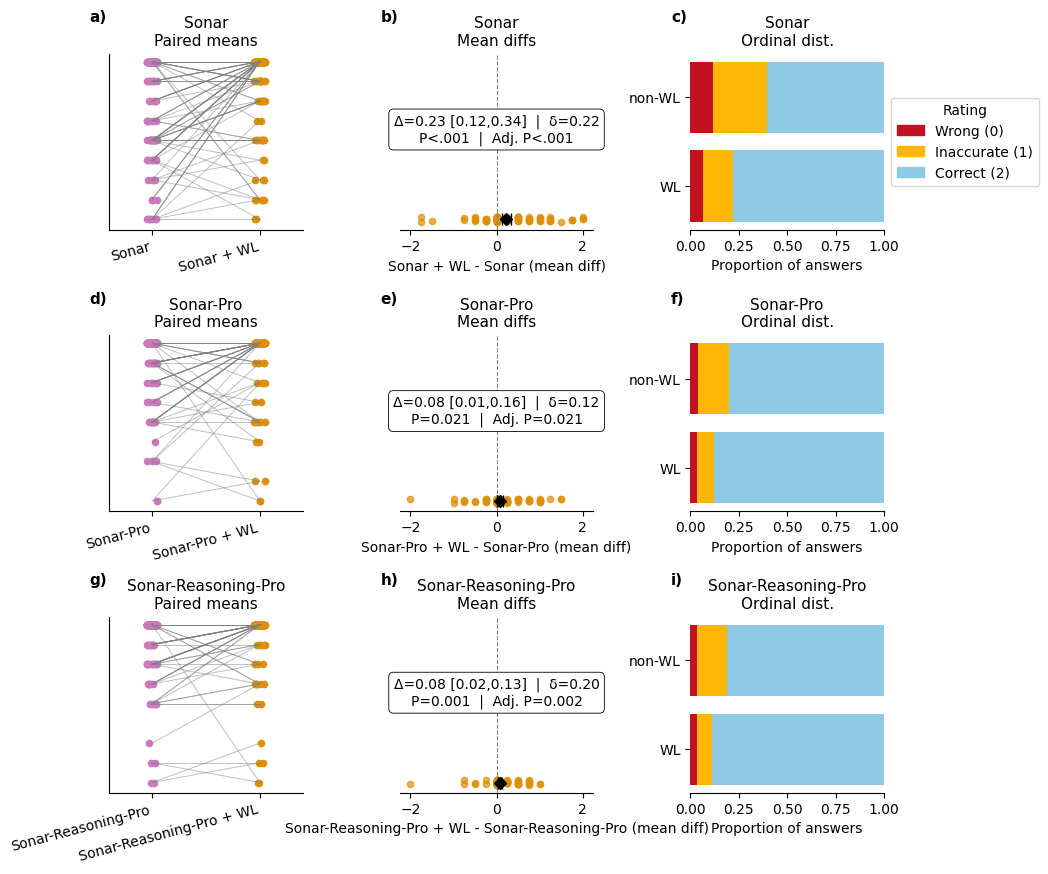

In [25]:
composite_by_model(data, "Visualizations/Figure 3.png")

# Analysis of Source Influence

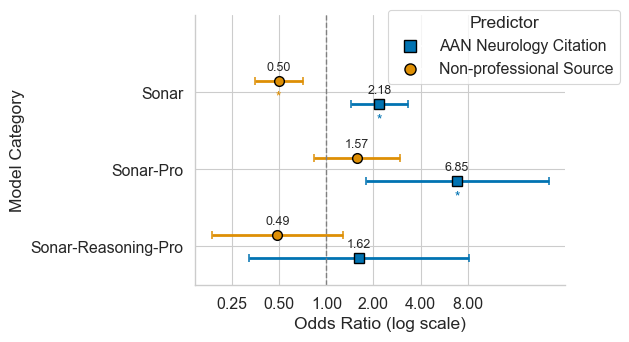

,Model,Feature,OR,P-value (Original),P-value (Adjusted),CI 2.5%,CI 97.5%
0,Sonar,Non-professional Source,0.50,P<.001,P<.001,0.35,0.71
1,Sonar,AAN Neurology Citation,2.18,P<.001,P<.001,1.43,3.31
2,Sonar-Pro,Non-professional Source,1.57,P=0.16,P=0.16,0.84,2.96
3,Sonar-Pro,AAN Neurology Citation,6.85,P=0.005,P=0.01,1.78,26.35
4,Sonar-Reasoning-Pro,Non-professional Source,0.49,P=0.14,P=0.29,0.19,1.28
5,Sonar-Reasoning-Pro,AAN Neurology Citation,1.62,P=0.56,P=0.56,0.32,8.14


In [22]:
# Cell ▸ Stratified Ordinal Logistic Regression & Publication-Ready Forest Plot (v2)
"""
Iterated version: clearer spacing, grouping, and annotation for npj Digital Medicine.
The forest plot now:
• Groups rows by *model_category* with adequate vertical spacing.
• Offsets predictors within each model (no overlap).
• Adds OR value labels and significance stars.
• Uses a colour-blind palette and distinct marker shapes.
• Saves high-resolution PNG & PDF.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from scipy.stats import chi2
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multitest import multipletests

# ----- 1. Outcome encoding ----------------------------------------------------
RATING_MAP = {'Wrong': 0, 'Inaccurate': 1, 'Correct': 2}
if 'rating_encoded' not in data.columns:
    data['rating_encoded'] = (data['Final Rating']
                              .map(RATING_MAP)
                              .astype('category')
                              .cat.reorder_categories([0, 1, 2], ordered=True))

# ----- 2. Predictors ----------------------------------------------------------
FEATURE_COLS = [ 'has_aan_neurology',"non_professional_binary"]
FEATURE_LABELS = {
    'has_aan_neurology':   'AAN Neurology Citation',
    'non_professional_binary': 'Non-professional Source'
}
MARKERS = {           'AAN Neurology Citation':  's',
           'Non-professional Source': 'o'}
PALETTE = sns.color_palette('colorblind', 2)

# ----- 3. Fit models & collect estimates --------------------------------------
rows = []
filtered_data = data[~data['model_category'].str.contains("WL", na=False)]
for model_name, grp in filtered_data.groupby('model_category'):
    y = grp['rating_encoded']
    if len(grp) < 10 or y.nunique() < 2:
        continue

    # Drop invariant features in this stratum
    active = [c for c in FEATURE_COLS if grp[c].nunique() > 1]
    X = grp[active].astype(float)
    if X.empty:
        continue

    res = OrderedModel(y, X, distr='logit').fit(method='bfgs', disp=False)
    res_null = OrderedModel(y, None, distr='logit').fit(method='bfgs', disp=False)
    lr_p = chi2.sf(-2*(res_null.llf-res.llf), res.df_model-res_null.df_model)

    for feat in active:
        coef, se = res.params[feat], res.bse[feat]
        or_ = np.exp(coef)
        ci_l, ci_u = np.exp(coef-1.96*se), np.exp(coef+1.96*se)
        rows.append({
            'Model': model_name,
            'Feature': FEATURE_LABELS[feat],
            'OR': or_, 'CI_low': ci_l, 'CI_up': ci_u,
            'p': res.pvalues[feat], 'LR_p': lr_p
        })

results = pd.DataFrame(rows)
results['p_adj'] = (results.groupby('Model')['p']
                           .transform(lambda p: multipletests(p, method='holm')[1]))
results['Sig'] = results['p_adj'] < 0.05

# Sort for plotting
results.sort_values(['Model', 'Feature'], ascending=[True, False], inplace=True)
results.reset_index(drop=True, inplace=True)

# ----- 4. Forest plot ---------------------------------------------------------
sns.set_theme(style='whitegrid', context='paper', font_scale=1.3)
fig_h = max(3, 0.6 * len(results))
fig, ax = plt.subplots(figsize=(6, fig_h))

# Determine base y positions (one slot per model)
models = results['Model'].unique()[::-1]  # reverse for top-to-bottom
base_y = {m: i*2 for i, m in enumerate(range(len(models)))}  # spaced by 2

# Plot
for idx, row in results.iterrows():
    y_base = list(models).index(row['Model'])*2
    # Offset within model: −0.3 for first feature, +0.3 for second, etc.
    feat_idx = list(MARKERS.keys()).index(row['Feature'])
    y = y_base + (feat_idx-0.5)*0.6
    err_low = row['OR'] - row['CI_low']
    err_up  = row['CI_up'] - row['OR']
    ax.errorbar(row['OR'], y,
                xerr=[[err_low], [err_up]],
                fmt=MARKERS[row['Feature']], mec='black', mfc=PALETTE[feat_idx],
                ms=7, ecolor=PALETTE[feat_idx], capsize=3, capthick=1.1, lw=2)
    # OR text
    ax.text(row['OR'], y+0.18, f"{row['OR']:.2f}", ha='center', va='bottom', fontsize=9)
    # significance star
    if row['Sig']:
        ax.text(row['OR'], y-0.25, '*', ha='center', va='top', color=PALETTE[feat_idx], fontsize=10)

# Aesthetics
ax.axvline(1, color='grey', lw=1, ls='--')
ax.set_xscale('log')
ax.set_xlabel('Odds Ratio (log scale)')
ax.set_yticks([base for base in range(0, len(models)*2, 2)])
ax.set_yticklabels(models)
ax.set_ylim(-1, len(models)*2)
ax.set_xticks([0.25, 0.5, 1, 2, 4, 8])
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_ylabel('Model Category')

# Legend
legend_handles = [plt.Line2D([0], [0], marker=MARKERS[lbl], color='w',
                             markerfacecolor=PALETTE[i], markeredgecolor='black',
                             label=lbl, markersize=8)
                   for i, lbl in enumerate(MARKERS)]
ax.legend(handles=legend_handles, title='Predictor', bbox_to_anchor=(0.5, 1.05), frameon=True)

sns.despine(ax=ax, left=False)
fig.tight_layout()

fig.savefig('Visualizations/Figure_4.png', dpi=600, bbox_inches='tight')
fig.savefig('Visualizations/Figure_4.pdf', bbox_inches='tight')
plt.show()

def format_p_value(p):
    if p < 0.001:
        return "P<.001"
    elif p < 0.01:
        return f"P={p:.3f}"
    elif p >= 0.99:
        return "P>.99"
    else:
        return f"P={p:.2f}"


# ----- 5. Tidy results table --------------------------------------------------
disp = (results[['Model','Feature','OR','p','p_adj','CI_low','CI_up']]
        .rename(columns={'CI_low':'CI 2.5%','CI_up':'CI 97.5%','p_adj':'P-value (Adjusted)', 'p':'P-value (Original)'}))

disp["P-value (Original)"] = disp["P-value (Original)"].apply(format_p_value)

disp["P-value (Adjusted)"] = disp["P-value (Adjusted)"].apply(format_p_value)

disp.round({'OR':2,'CI 2.5%':2,'CI 97.5%':2})


In [23]:
from docx import Document
from docx.shared import Pt
from docx.oxml.ns import qn

# Helper to write into a cell with proper font

def set_cell_text(cell, text, bold=False, font_size=12):
    para = cell.paragraphs[0]
    run = para.add_run(str(text))
    run.bold = bold
    run.font.name = 'Times New Roman'
    run._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
    run.font.size = Pt(font_size)
# Section 2: Ordinal Logistic Regression Source Results
doc2 = Document()
# Apply same default style
style2 = doc2.styles['Normal']
style2.font.name = 'Times New Roman'
style2._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
style2.font.size = Pt(12)

doc2.add_heading('Ordinal Logistic Regression Results by Model', level=1)
doc2.add_paragraph(
    "Note: Odds Ratios represent the likelihood of higher performance "
    "('Correct' > 'Inaccurate' > 'Wrong') for each predictor, adjusted using Holm correction.",
    style='Normal'
)

# Table using disp DataFrame columns
tbl_header = list(disp.columns)
table2 = doc2.add_table(rows=1, cols=len(tbl_header))
table2.style = 'Table Grid'
# Header row
for idx, col_name in enumerate(tbl_header):
    set_cell_text(table2.rows[0].cells[idx], col_name, bold=True)

# Populate rows
for _, row in disp.iterrows():
    cells = table2.add_row().cells
    for i, val in enumerate(row):
        text = f"{val:.4g}" if isinstance(val, float) else str(val)
        set_cell_text(cells[i], text)

# Save document
output_path2 = 'Results/ordinal_source_results.docx'
doc2.save(output_path2)
print(f"📄 Word file saved to: {output_path2}")


📄 Word file saved to: Results/ordinal_source_results.docx


In [24]:
# count of rows per model
total = data.groupby('model_category').size().rename('Total rows')

# sum up each binary feature per model
attr_counts = (
    data
    .groupby('model_category')[FEATURE_COLS]
    .sum()
    .rename(columns=FEATURE_LABELS)
)

# combine into one table
overview = pd.concat([total, attr_counts], axis=1)
overview

,Total rows,AAN Neurology Citation,Non-professional Source
model_category,,,
OpenEvidence (Assumed WL),520,520,0
Sonar,520,428,234
Sonar + WL,520,520,20
Sonar-Pro,520,514,468
Sonar-Pro + WL,520,520,34
Sonar-Reasoning-Pro,520,512,474
Sonar-Reasoning-Pro + WL,520,520,31


# Analysis per Guideline

In [25]:

guidelines_info = {
    "Guideline": [
        "Teratogenesis, Perinatal, and Neurodevelopmental Outcomes After In Utero Exposure to Antiseizure Medication",
        "Pediatric and Adult Brain Death/Death by Neurologic Criteria Consensus Practice Guideline",
        "Stroke Prevention in Symptomatic Large Artery Intracranial Atherosclerosis",
        "Oral and topical treatment of painful diabetic polyneuropathy practice guideline update",
        "Antiseizure medication withdrawal in seizure-free patients practice advisory update",
        "Dopaminergic Therapy for Motor Symptoms in Early Parkinson Disease",
        "Guidelines for the Prevention, Diagnosis, and Treatment of Lyme Disease",
        "Patent foramen ovale and secondary stroke prevention",
        "Treatment for Insomnia and Disrupted Sleep Behavior in Children and Adolescents with Autism Spectrum Disorder",
        "Vaccine-preventable Infections and Immunization in Multiple Sclerosis",
        "Acute Treatment of Migraine in Children and Adolescents",
        "Pharmacologic Treatment for Pediatric Migraine Prevention",
        "Treatment of Tics in People with Tourette Syndrome and Chronic Tic Disorders"
    ],
    "Date Published": [
        "May 15, 2024",
        "December 6, 2023",
        "March 21, 2022",
        "December 27, 2021",
        "December 6, 2021",
        "November 15, 2021",
        "November 30, 2020",
        "April 29, 2020",
        "February 12, 2020",
        "August 28, 2019",
        "August 14, 2019",
        "August 14, 2019",
        "May 6, 2019"
    ],
    "Date Reaffirmed": [
        "N/A",
        "N/A",
        "N/A",
        "N/A",
        "N/A",
        "N/A",
        "October 21, 2023",
        "July 14, 2023",
        "February 25, 2023",
        "October 22, 2022",
        "October 22, 2022",
        "October 22, 2022",
        "April 30, 2022"
    ]
}

guidelines_df = pd.DataFrame(guidelines_info)
guidelines_df["Date Published"] = pd.to_datetime(guidelines_df["Date Published"])

In [26]:
guidelines_list = [
    {
        "Guideline": "Teratogenesis, Perinatal, and Neurodevelopmental Outcomes After In Utero Exposure to Antiseizure Medication",
        "start_q": 1,
        "end_q": 10
    },
    {
        "Guideline": "Pediatric and Adult Brain Death/Death by Neurologic Criteria Consensus Practice Guideline",
        "start_q": 11,
        "end_q": 20
    },
    {
        "Guideline": "Stroke Prevention in Symptomatic Large Artery Intracranial Atherosclerosis",
        "start_q": 21,
        "end_q": 30
    },
    {
        "Guideline": "Oral and topical treatment of painful diabetic polyneuropathy practice guideline update",
        "start_q": 31,
        "end_q": 40
    },
    {
        "Guideline": "Antiseizure medication withdrawal in seizure-free patients practice advisory update",
        "start_q": 41,
        "end_q": 50
    },
    {
        "Guideline": "Dopaminergic Therapy for Motor Symptoms in Early Parkinson Disease",
        "start_q": 51,
        "end_q": 60
    },
    {
        "Guideline": "Guidelines for the Prevention, Diagnosis, and Treatment of Lyme Disease",
        "start_q": 61,
        "end_q": 70
    },
    {
        "Guideline": "Patent foramen ovale and secondary stroke prevention",
        "start_q": 71,
        "end_q": 80
    },
    {
        "Guideline": "Treatment for Insomnia and Disrupted Sleep Behavior in Children and Adolescents with Autism Spectrum Disorder",
        "start_q": 81,
        "end_q": 90
    },
    {
        "Guideline": "Vaccine-preventable Infections and Immunization in Multiple Sclerosis",
        "start_q": 91,
        "end_q": 100
    },
    {
        "Guideline": "Acute Treatment of Migraine in Children and Adolescents",
        "start_q": 101,
        "end_q": 110
    },
    {
        "Guideline": "Pharmacologic Treatment for Pediatric Migraine Prevention",
        "start_q": 111,
        "end_q": 120
    },
    {
        "Guideline": "Treatment of Tics in People with Tourette Syndrome and Chronic Tic Disorders",
        "start_q": 121,
        "end_q": 130
    }
]

# Build the question mapping DataFrame
guideline_question_data = []
for g in guidelines_list:
    for qnum in range(g["start_q"], g["end_q"] + 1):
        guideline_question_data.append({
            "Guideline": g["Guideline"],
            "Question Number": qnum,
        })

gq_df = pd.DataFrame(guideline_question_data)


In [27]:
# data drop " Guideline"
data.drop(columns=["Guideline"], inplace=True)

In [28]:

# Now merge data with gq_df to get the Guideline info
data_merged = pd.merge(
    data,
    gq_df,
    left_on="Question Number",
    right_on="Question Number",
    how="left"
)

In [29]:


# Then merge with guidelines_df to get Date Published, etc.
data_final = pd.merge(
    data_merged,
    guidelines_df,
    on="Guideline",
    how="left"
)

In [30]:

short_name_map = {
    "Teratogenesis, Perinatal, and Neurodevelopmental Outcomes After In Utero Exposure to Antiseizure Medication": "Teratogenesis & ASM",
    "Pediatric and Adult Brain Death/Death by Neurologic Criteria Consensus Practice Guideline": "Brain Death Criteria",
    "Stroke Prevention in Symptomatic Large Artery Intracranial Atherosclerosis": "Stroke Prev (ICAS)",
    "Oral and topical treatment of painful diabetic polyneuropathy practice guideline update": "Diabetic Polyneuropathy",
    "Antiseizure medication withdrawal in seizure-free patients practice advisory update": "ASM Withdrawal",
    "Dopaminergic Therapy for Motor Symptoms in Early Parkinson Disease": "Parkinson Motor Tx",
    "Guidelines for the Prevention, Diagnosis, and Treatment of Lyme Disease": "Lyme Disease",
    "Patent foramen ovale and secondary stroke prevention": "PFO & Stroke",
    "Treatment for Insomnia and Disrupted Sleep Behavior in Children and Adolescents with Autism Spectrum Disorder": "Insomnia in Autism",
    "Vaccine-preventable Infections and Immunization in Multiple Sclerosis": "MS Vaccinations",
    "Acute Treatment of Migraine in Children and Adolescents": "Acute Migraine in Adolescents",
    "Pharmacologic Treatment for Pediatric Migraine Prevention": "Migraine Prev in Adolescents",
    "Treatment of Tics in People with Tourette Syndrome and Chronic Tic Disorders": "Tics & Tourette"
}

# b) Extract year from Date Published and build "ShortNameYear"
data_final["Year"] = data_final["Date Published"].dt.year.astype(str)
data_final["Short Guideline"] = data_final["Guideline"].map(short_name_map)
data_final["ShortNameYear"] =  data_final["Year"] + ": " + data_final["Short Guideline"].astype(str)

# c) Sort guidelines by date to define an ordered category
guidelines_sorted = (
    data_final[["Guideline", "Date Published"]]
    .drop_duplicates()
    .sort_values("Date Published")
)
ordered_guidelines = guidelines_sorted["Guideline"].tolist()

data_final["Guideline"] = pd.Categorical(
    data_final["Guideline"],
    categories=ordered_guidelines,
    ordered=True
)

# d) For plotting, we also want an ordered ShortNameYear in the same order
#    We'll create a small helper mapping from Guideline -> ShortNameYear
_guide_to_short = (
    data_final[["Guideline", "ShortNameYear"]]
    .drop_duplicates()
    .set_index("Guideline")["ShortNameYear"]
    .to_dict()
)
# Re-map in that sorted order
data_final["ShortNameYear"] = data_final["Guideline"].map(_guide_to_short)
ordered_shortnames = [ _guide_to_short[g] for g in ordered_guidelines ]



In [31]:

data_final["IsCorrect"] = data_final["Final Rating"].eq("Correct")
pct_correct = (
    data_final
    .groupby(["ShortNameYear", "model_category"], as_index=False)["IsCorrect"]
    .mean()
)
pct_correct["Correct (%)"] = pct_correct["IsCorrect"] * 100

/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_64605/1501185499.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_final


/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_64605/2870851309.py:8: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(
/var/folders/l_/hnp4n5y13k3dbz2xfjjz44p00000gn/T/ipykernel_64605/2870851309.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.pointplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


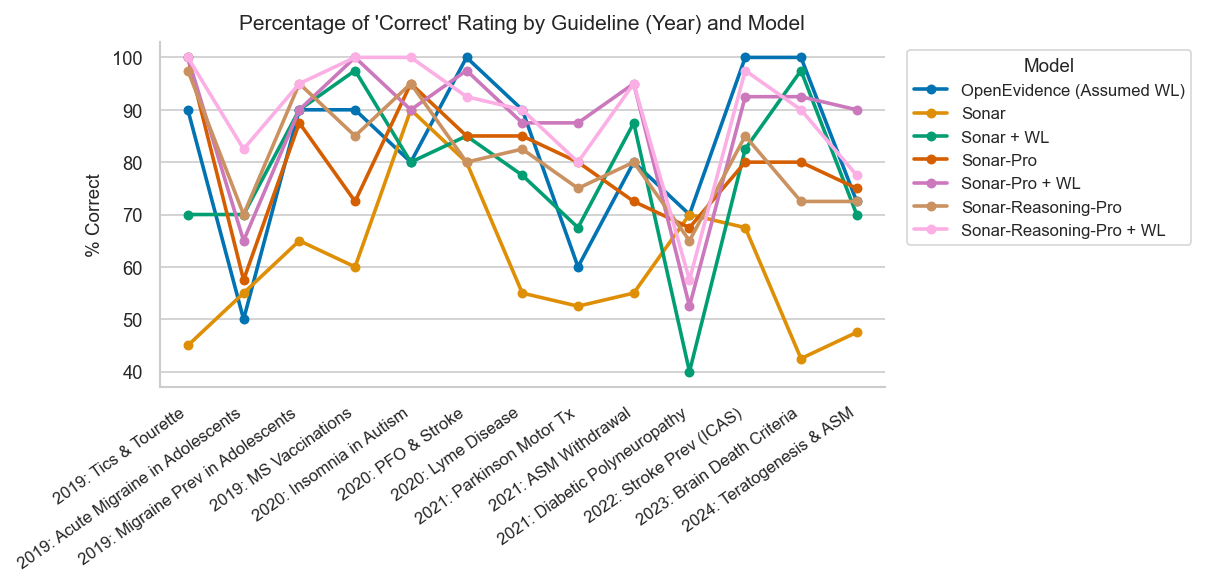

In [32]:

# Example: smaller context, colorblind palette
sns.set_theme(style="whitegrid", context="paper", palette="colorblind")

# For a leaner figure, reduce figure size
plt.figure(figsize=(8, 4), dpi=150)

# Create a point plot with lighter lines, smaller markers
ax = sns.pointplot(
    data=pct_correct,
    x="ShortNameYear",       # or your x-axis column
    y="Correct (%)",
    hue="model_category",
    linestyles="-",
    markers="o",
    dodge=0,
    scale=0.8,               # controls relative marker size
    errwidth=0,              # hide error bars or set them smaller
)

# Make x‐axis labels smaller & rotated
plt.xticks(rotation=35, ha="right", fontsize=8)

# Adjust axis labels & title font sizes
plt.xlabel("")  # or shorten label text
plt.ylabel("% Correct", fontsize=9)
plt.title("Percentage of 'Correct' Rating by Guideline (Year) and Model", fontsize=10)

# Move legend outside; use smaller text
plt.legend(
    title="Model", 
    bbox_to_anchor=(1.02, 1), 
    loc="upper left",
    fontsize=8,       # smaller legend font
    title_fontsize=9  # smaller title
)

# Optionally remove spines or lighten them
sns.despine(left=False, bottom=False)

plt.tight_layout()

plt.savefig('Visualizations/Correct_Over_Time.png', dpi=300)
plt.savefig('Visualizations/Correct_Over_Time.eps', dpi=300)
plt.savefig('Visualizations/Correct_Over_Time.svg', dpi=300)
plt.show()


# Interrater Agreement (ToDo)


In [33]:
from sklearn.metrics import cohen_kappa_score

# Extract the ratings from Rater 1 and Rater 2
rater_1 = data['Rater 1 (LM)']
rater_2 = data['Rater 2 (MP)']

# Drop rows where either rater's value is NaN
ratings = data[['Rater 1 (LM)', 'Rater 2 (MP)']]
rater_1_clean = ratings['Rater 1 (LM)']
rater_2_clean = ratings['Rater 2 (MP)']

# Calculate Cohen's Kappa
cohen_kappa = cohen_kappa_score(rater_1_clean, rater_2_clean)

# Calculate percentage agreement
total_ratings = len(rater_1_clean)
agreements = (rater_1_clean == rater_2_clean).sum()
percentage_agreement = agreements / total_ratings * 100

# Display the results
cohen_kappa, percentage_agreement


(np.float64(0.8578344227895452), np.float64(95.27472527472527))

## Double checking version

In [2]:

import pkg_resources

# Get all installed packages and their versions
installed_packages = pkg_resources.working_set
package_list = sorted([f"{dist.key} {dist.version}" for dist in installed_packages])

# Print each package and version
for package in package_list:
    print(package)


annotated-types 0.7.0
anyio 4.8.0
appnope 0.1.4
argon2-cffi 23.1.0
argon2-cffi-bindings 21.2.0
arrow 1.3.0
asttokens 3.0.0
async-lru 2.0.4
attrs 25.1.0
babel 2.17.0
beautifulsoup4 4.13.3
bleach 6.2.0
certifi 2025.1.31
cffi 1.17.1
charset-normalizer 3.4.1
comm 0.2.2
contourpy 1.3.0
cycler 0.12.1
debugpy 1.8.13
decorator 5.2.1
defusedxml 0.7.1
distro 1.9.0
et-xmlfile 2.0.0
exceptiongroup 1.2.2
executing 2.2.0
fastjsonschema 2.21.1
fonttools 4.57.0
fqdn 1.5.1
graphviz 0.20.3
h11 0.14.0
httpcore 1.0.7
httpx 0.28.1
idna 3.10
importlib-metadata 8.6.1
importlib-resources 6.5.2
ipykernel 6.29.5
ipython 8.18.1
ipywidgets 8.1.5
isoduration 20.11.0
jedi 0.19.2
jinja2 3.1.5
jiter 0.9.0
joblib 1.5.0
json5 0.10.0
jsonpointer 3.0.0
jsonschema 4.23.0
jsonschema-specifications 2024.10.1
jupyter 1.1.1
jupyter-client 8.6.3
jupyter-console 6.6.3
jupyter-core 5.7.2
jupyter-events 0.12.0
jupyter-lsp 2.2.5
jupyter-server 2.15.0
jupyter-server-terminals 0.5.3
jupyterlab 4.3.5
jupyterlab-pygments 0.3.0
jupyter